# Comparison for cluster parameters 

Cluster parameters obtained by either DBSCAN or HDBSCAN are compared with the original, but scaled, data

**NOTE**
Data for July of each year (2015-2021) are loaded and stored in a list of dataframes. 
In the publication we compare the year 2015 = list index 0 and 2017 = list index 2!

You need to adapt this list index number for reproducing the graphics!

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

### Load in the data

In [435]:
data = []
for i in range(15,21):
    data.append(pd.read_csv(f"monthly_footprint_xy_csv/july_{i}.csv"))

In [437]:
DX = []
for i in range(len(data)):
    DX.append(pd.DataFrame.to_numpy(data[i][['x','y']]))

### Scale the data

In [438]:
DXs = []
for i in range(len(DX)):
    DXs.append(RobustScaler().fit_transform(DX[i]))

### Create a joined plot using 2D histogram

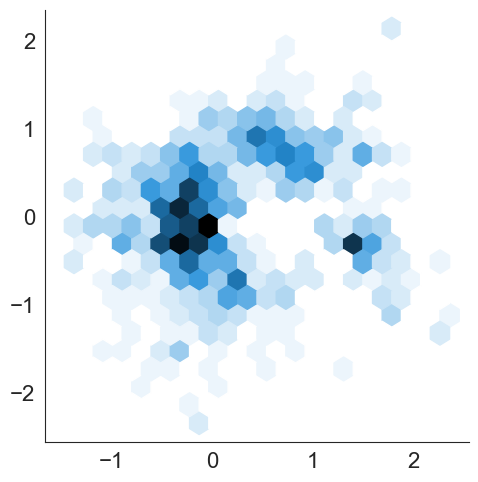

In [441]:
import seaborn as sns
sns.set_style("white")
g = sns.jointplot(x=DXs[2][:,0], y=DXs[2][:,1], kind='hex', marginal_kws=dict(bins=30, fill=True))
g.ax_marg_x.remove()
g.ax_marg_y.remove()
plt.show()

### Retrieve the clusters using eps=0.15 and min_samples=17 for DBSCAN

In [442]:
labels = []
n_clusters_ = []
n_noise = []
unique_labels = []
core_samples_mask = []

for i in range(len(DXs)):
    db = DBSCAN(eps=0.15, min_samples=17).fit(DXs[i])
    lbs = db.labels_
    labels.append(lbs)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_.append(len(set(lbs)) - (1 if -1 in lbs else 0))
    n_noise_ = list(lbs).count(-1)

    unique_labels.append(set(lbs))
    csm = np.zeros_like(lbs, dtype=bool)
    csm[db.core_sample_indices_] = True
    core_samples_mask.append(csm)

In [443]:
db.labels_.shape, labels[2].shape

((902,), (855,))

In [444]:
unique_labels

[{-1, 0, 1},
 {-1, 0, 1, 2},
 {-1, 0, 1, 2, 3, 4},
 {-1, 0, 1, 2},
 {-1, 0, 1},
 {-1, 0, 1, 2}]

### Function to plot DBSCAN results including different coloring and shapes for DBSCAN 

In [445]:
plt.rcParams['figure.figsize'] = [5, 5]

def plotClusters(idx):

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels[idx]))]
    for k, col in zip(unique_labels[idx], colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels[idx] == k

        xy = DXs[idx][class_member_mask & core_samples_mask[idx]]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "x" if k == -1 else "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            #markersize=14,
            markersize=4 if k == -1 else 1 + 7,
            alpha=0.5 if k == -1 else 1,
        )

        xy = DXs[idx][class_member_mask & ~core_samples_mask[idx]]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "x" if k == -1 else "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            #markersize=6,
            markersize=4 if k == -1 else 1 + 3,
            alpha=0.5 if k == -1 else 1,
        )

    plt.title(f"C: Estimated number of clusters: {n_clusters_[idx]}")
    #plt.show()

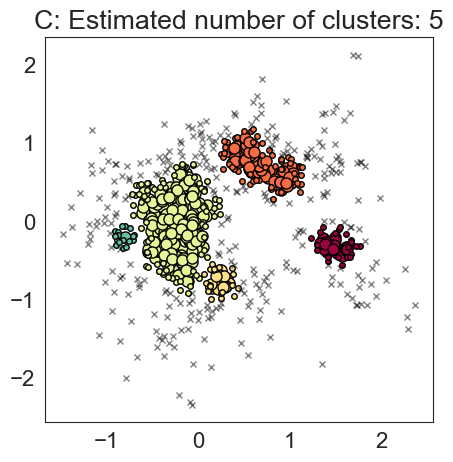

In [446]:
plotClusters(2)

### Retrieve the clusters using eps=0.15 and min_samples=17 for HDBSCAN

In [447]:
hdb = HDBSCAN(min_samples=17, cluster_selection_epsilon=0.15).fit(DXs[2])

### Function to plot DBSCAN results including different coloring and shapes for HDBSCAN 

In [448]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None, tt=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 7 * proba_map[ci],
                alpha=0.5 if k == -1 else 1,
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{tt}: {preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

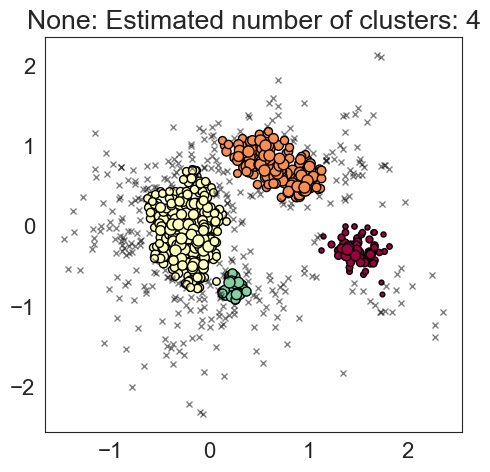

In [449]:
plot(
        DXs[2],
        hdb.labels_,
        hdb.probabilities_,
    )

### Create plot for publication

**NOTE**
Change the list index and file name for different output!

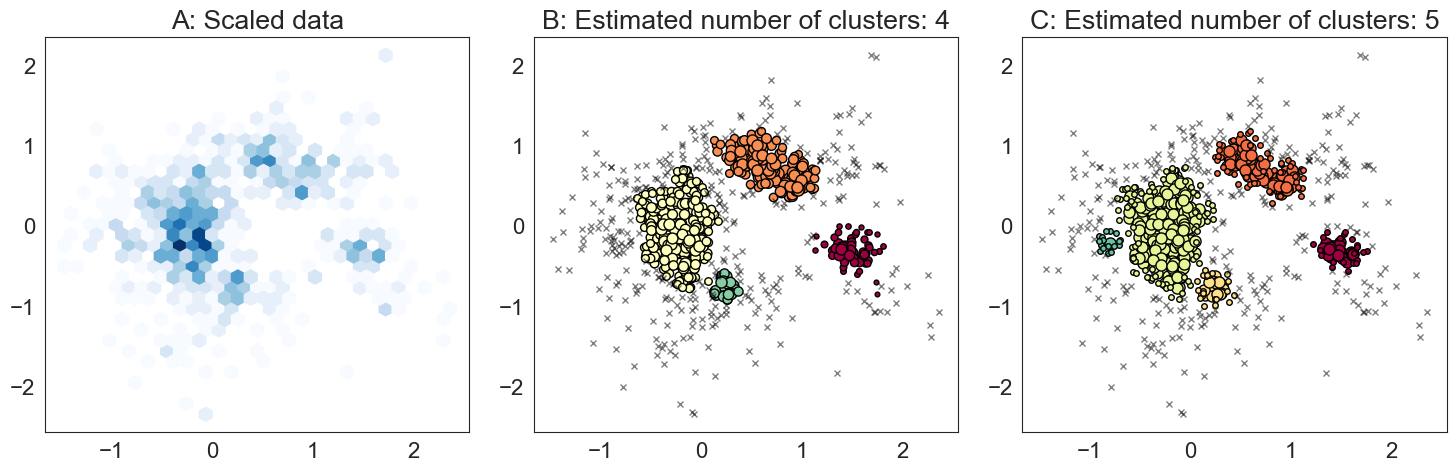

In [458]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(15,5))
axs = fig.subplots(1,3)
axs[0].hexbin(DXs[2][:,0], DXs[2][:,1], gridsize=30, cmap='Blues', mincnt=1)
axs[0].set_title('A: Scaled data')   
#HDBSCAN
plot(
        DXs[2],
        hdb.labels_,
        hdb.probabilities_,
        ax=axs[1],
        tt="B",
    )
#DBSCAN
plotClusters(2)

plt.savefig('excluster2.pdf')


### Compare counts of labes for HDBSCAN and DBSCAN

In [461]:
for i in set(db.labels_):
    print(i, np.where(hdb.labels_ == i)[0].shape, np.where(db.labels_ == i)[0].shape)

0 (61,) (45,)
1 (133,) (358,)
2 (298,) (44,)
-1 (337,) (455,)
